In [152]:
import pandas as pd
import geopandas as gpd

from bokeh.plotting import figure, show
from bokeh.models import GeoJSONDataSource, ColumnDataSource, HoverTool


import sys

sys.path.append("../")

from Code.helper_functions import initial_loading

## Zuidoost

In [165]:
df_zo = pd.read_csv('../Results/20200510 - cluster optimization/hillclimber_best_config20200509-1228.csv')
all_households, rel_poi_df, joined, df_afstandn2 = initial_loading()

Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection(optional parameter)?T
What is the maximum amount of containers in a cluster that is considered to be useful?8
Where to get db files(local/online)?local
DB relation POIs loaded


..\Code\loading_data.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verblijfsobjecten['bag'] = verblijfsobjecten['split'].apply(lambda x: x[3])\


distance matrix loaded
API data loaded
Table all households created
API and DB joined
containers per cluster determined


In [166]:
df_zo = df_zo.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

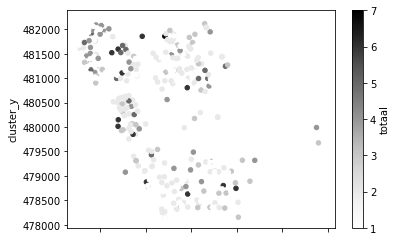

In [167]:
to_join = df_zo[['s1_afv_nodes', 'rest', 'plastic', 'papier', 'glas', 'textiel', 'totaal']].set_index('s1_afv_nodes')
joined.s1_afv_nodes = joined.s1_afv_nodes.astype('int')
new = to_join.join(joined.set_index('s1_afv_nodes'), lsuffix='_n')
new.plot(kind='scatter', x='cluster_x', y='cluster_y', c='totaal')

In [168]:
households_zo = all_households[(all_households['cluster_x'] > 123600) & (all_households['cluster_y'] < 482600)]
households_zo = households_zo.set_index('naar_s1_afv_nodes').join(df_afstandn2[['count', 'naar_s1_afv_nodes']].set_index('naar_s1_afv_nodes'), how='left').drop_duplicates()

In [170]:
load = gpd.read_file('../data/Inzameling_huisvuil_100220.shp')

street_map = load[load['sdcode'] == 'T']
geosource = GeoJSONDataSource(geojson = street_map.to_json())
street_map_clean = street_map[street_map['aanbiedwij'] == 'Breng uw restafval  naar een container voor restafval.']
geosource2 = GeoJSONDataSource(geojson = street_map_clean.to_json())

TOOLTIPS = [
("index", "$index"),
("(x,y)", "($x, $y)"),
("Rest", "(@rest, @rest_n)"),
("Plastic", "(@plastic, @plastic_n)"),
("Papier", "(@papier, @papier_n)"),
("Glas", "(@glas, @glas_n)"),
("Textiel", "(@textiel, @textiel_n)")
]

TOOLTIPS2 = [
("index", "$index"),
("(x,y)", "($x, $y)"),
("Count", "@count")]

source = ColumnDataSource(data=new)
source2 = ColumnDataSource(data=households_zo)


p = figure()
r1 = p.patches('xs', 'ys', source=geosource, fill_color='grey', alpha=0.1, line_color=None)
r2 = p.patches('xs', 'ys', source=geosource2, fill_color='grey', alpha=0.3, line_color=None)
r3 = p.circle(x='cluster_x', y='cluster_y', color='red', line_color=None, source=source, radius=20)
p.add_tools(HoverTool(renderers=[r3], tooltips=TOOLTIPS))
# p.circle(x=new[new['rest'] > 0]['cluster_x'], y=new[new['rest'] > 0]['cluster_y'], fill_color='red', line_color=None, radius=15, alpha=0.5)
# p.circle(x=new[new['rest'] == 0]['cluster_x'], y=new[new['rest'] == 0]['cluster_y'], fill_color='orange', line_color=None, radius=15, alpha=0.5)
r4 = p.circle(x='cluster_x', y='cluster_y', radius=1.5, source=source2)
p.add_tools(HoverTool(renderers=[r4], tooltips=TOOLTIPS2))


show(p)

In [130]:
# Bokeh interactive representation
def to_bokeh_interactive(df):
    TOOLS="crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
    
    # Configuring hover over tooltip
    TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("Rest", "@rest"),
    ("Plastic", "@plastic"),
]

    colors = {'Rest':'grey', 'Papier':'red', 'Plastic':'orange', 'Glas':'green', 'Textiel': 'blue', 'Brood': 'purple', None: 'pink'}
    p = figure(tools=TOOLS, tooltips = TOOLTIPS, title="Garbage Containers in Amsterdam", x_range=(110000, 135000), y_range=(475000, 495000), plot_width = 750, plot_height=600)
    
    # To be able to name them
    for fraction in df.fractie.unique():
        if fraction != None:
            df_temp = df[df['fractie'] == fraction]
            p.circle(x = df_temp['x'], y = df_temp['y'], fill_color=colors[fraction], line_width=0, radius=10, name=fraction, legend_label=str(fraction))
    p.patches('xs', 'ys', source=geosource, fill_color='grey', alpha=0.2)
#     p.patches('xs', 'ys', source=geosource2, fill_color='grey', alpha=0.2)
    p.patches('xs', 'ys', source=geosource3, fill_color='grey', alpha=0.2)
    p.legend.location = "bottom_left"
    output_file("garbage_containers.html")
    show(p)
    return p

## Other pieces

In [182]:
def visualise_configuration():
    coordinates_dict = {'T':[123600, 131000, 476500, 482700],
                        'N':[110000, 135000, 486000, 495000]}
    filename = input("Please provide the requested filename")
    area = input("Provide Code of neighborhood (T/N/F/C)")
    df_zo = pd.read_csv(filename)
    df_zo = df_zo.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
    
    all_households, rel_poi_df, joined, df_afstandn2 = initial_loading()
    
    to_join = df_zo[['s1_afv_nodes', 'rest', 'plastic', 'papier', 'glas', 'textiel', 'totaal']].set_index('s1_afv_nodes')
    joined.s1_afv_nodes = joined.s1_afv_nodes.astype('int')
    new = to_join.join(joined.set_index('s1_afv_nodes'), lsuffix='_n')
    
    households_zo = all_households[(all_households['cluster_x'] > coordinates_dict[area][0]) & (all_households['cluster_x'] < coordinates_dict[area][1]) & (all_households['cluster_y'] > coordinates_dict[area][2]) & (all_households['cluster_y'] < coordinates_dict[area][3])]
    households_zo = households_zo.set_index('naar_s1_afv_nodes').join(df_afstandn2[['count', 'naar_s1_afv_nodes']].set_index('naar_s1_afv_nodes'), how='left').drop_duplicates()

    load = gpd.read_file('../data/Inzameling_huisvuil_100220.shp')

    street_map = load[load['sdcode'] == area]
    geosource = GeoJSONDataSource(geojson = street_map.to_json())
    street_map_clean = street_map[street_map['aanbiedwij'] == 'Breng uw restafval  naar een container voor restafval.']
    geosource2 = GeoJSONDataSource(geojson = street_map_clean.to_json())

    TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("Rest", "(@rest, @rest_n)"),
    ("Plastic", "(@plastic, @plastic_n)"),
    ("Papier", "(@papier, @papier_n)"),
    ("Glas", "(@glas, @glas_n)"),
    ("Textiel", "(@textiel, @textiel_n)")
    ]

    TOOLTIPS2 = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("Count", "@count")]

    source = ColumnDataSource(data=new)
    source2 = ColumnDataSource(data=households_zo)


    p = figure()
    r1 = p.patches('xs', 'ys', source=geosource, fill_color='grey', alpha=0.1, line_color=None)
    r2 = p.patches('xs', 'ys', source=geosource2, fill_color='grey', alpha=0.3, line_color=None)
    r3 = p.circle(x='cluster_x', y='cluster_y', color='red', line_color=None, source=source, radius=20)
    p.add_tools(HoverTool(renderers=[r3], tooltips=TOOLTIPS))
    r4 = p.circle(x='cluster_x', y='cluster_y', radius=1.5, source=source2)
    p.add_tools(HoverTool(renderers=[r4], tooltips=TOOLTIPS2))

    show(p)
    return p

In [ ]:
kaartje = visualise_configuration()

Please provide the requested filename../Results/20200510 - cluster optimization/hillclimber_best_config20200509-2116.csv
Provide Code of neighborhood (T/N/F/C)N
Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection(optional parameter)?
What is the maximum amount of containers in a cluster that is considered to be useful?8
Where to get db files(local/online)?local
DB relation POIs loaded
distance matrix loaded


In [184]:
show(kaartje)